In [1]:
import numpy as np
import sys
sys.path.append('..')
from common.layers import MatMul
from common.util import preprocess
from common.functions import sigmoid

class LSTM:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape
    
    A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

    # slice
    f = A[:, :H] # forget
    g = A[:, H:2*H] # generate
    i = A[:, 2*H:3*H] # input
    o = A[:, 3*H:] # output
    
    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)
    
    c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next)
    
    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

In [2]:
class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateFul=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
    self.layers = None

    self.h, self.c = None, None
    self.dh = None
    self.stateFul = stateFul

  def forward(self, xs):
    # 入力値に対する重み・出力値に対する重み・バイアス
    Wx, Wh, b = self.params
    # xs は (バッチサイズN, 時間長T, 入力次元D) の入力データ
    N, T, D = xs.shape
    # 出力値に対する重みの1次元目の要素数
    H = Wh.shape[0]
    
    self.layers = []
    hs = np.empty((N, T, H), dtype='f')
    
    if not self.stateFul or self.h is None:
      self.h = np.zeros((N, H), dtype='f')
    if not self.stateFul or self.c is None:
      self.c = np.zeros((N, H), dtype='f')

    # 書く時間毎（LSTM毎）に対して、LGTMレイヤを作成
    # self.hは初期状態は零配列になっていて、tのindexが0の時に初回更新される
    # index分、再帰的にhが更新される
    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
      hs[:, t, :] = self.h
      # [:, t, :] → 対象の時間tに対応する出力結果を更新

      self.layers.append(layer)
      
    return hs
  
  # dhsは各時間毎の出力値に対する勾配が格納
  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0] # 1時間毎の入力の次元数
    
    dxs = np.empty((N, T, D), dtype='f')
    dh, dc = 0, 0
    
    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      # dhs[:, t, :] + dh : 今回している時間tの出力hに対する勾配 + 未来の時間t_nextから流れてきた勾配
      # dc : 記憶セルの状態の勾配
      # dx : このステップの入力 x に対する勾配
      # dh : 前のステップに渡す隠れ状態の勾配
      # dc : 前のステップに渡すセル状態の勾配
      dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
      dxs[:, t, :] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] +=grad

    for i, grad in enumerate(grads):
      self.grads[i][...] = grad

    self.dh = dh
    return dxs
    
  def set_state(self, h, c=None):
    self.h, self.c = h, c

  def reset_state(self):
    self.h, self.c = None, None



Done
| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9998.51
| epoch 1 |  iter 21 / 1327 | time 1[s] | perplexity 2903.63
| epoch 1 |  iter 41 / 1327 | time 2[s] | perplexity 1241.51
| epoch 1 |  iter 61 / 1327 | time 3[s] | perplexity 961.71
| epoch 1 |  iter 81 / 1327 | time 4[s] | perplexity 791.29
| epoch 1 |  iter 101 / 1327 | time 5[s] | perplexity 655.29
| epoch 1 |  iter 121 / 1327 | time 7[s] | perplexity 647.85
| epoch 1 |  iter 141 / 1327 | time 8[s] | perplexity 590.85
| epoch 1 |  iter 161 / 1327 | time 9[s] | perplexity 547.00
| epoch 1 |  iter 181 / 1327 | time 10[s] | perplexity 593.25
| epoch 1 |  iter 201 / 1327 | time 11[s] | perplexity 497.76
| epoch 1 |  iter 221 / 1327 | time 12[s] | perplexity 492.51
| epoch 1 |  iter 241 / 1327 | time 13[s] | perplexity 434.84
| epoch 1 |  iter 261 / 1327 | time 15[s] | perplexity 441.39
| epoch 1 |  iter 281 / 1327 | time 16[s] | perplexity 427.07
| epoch 1 |  iter 301 / 1327 | time 17[s] | perplexity 388.87
| epoch 1 |  it

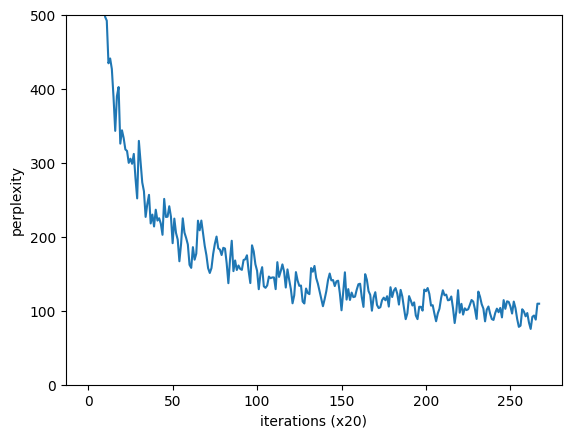

evaluating perplexity ...
234 / 235
test perplexity:  136.33968885643154


In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.rnnlm import Rnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 35  # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()


In [3]:
import sys
sys.path.append('..')
from common.time_layers import *
import pickle

class Rnnlm:
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4 * H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')
    
    self.layers = [
      TimeEmbedding(embed_W),
      TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
      TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = self.layers[1]
    
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def predict(self, xs):
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs
  
  # xs: 入力値
  # ts: 正解ラベル
  def forward(self, xs, ts):
    score = self.predict(xs)
    loss = self.loss_layer.forward(score, ts)
    return loss
  
  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout
  
  def reset_state(self):
    self.lstm_layer.reset_state()
  
  def save_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'wb') as f:
      pickle.dump(self.params, f)
      
  def load_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'rb') as f:
      self.params = pickle.load(f)

In [ ]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vacab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = Rnnlm(vacab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

model.save_params()

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9998.11
| epoch 1 |  iter 21 / 1327 | time 1[s] | perplexity 3095.95
| epoch 1 |  iter 41 / 1327 | time 2[s] | perplexity 1223.94
| epoch 1 |  iter 61 / 1327 | time 3[s] | perplexity 964.94
| epoch 1 |  iter 81 / 1327 | time 5[s] | perplexity 827.02
| epoch 1 |  iter 101 / 1327 | time 6[s] | perplexity 644.28
| epoch 1 |  iter 121 / 1327 | time 7[s] | perplexity 640.94
| epoch 1 |  iter 141 / 1327 | time 8[s] | perplexity 610.17
| epoch 1 |  iter 161 / 1327 | time 10[s] | perplexity 590.35
| epoch 1 |  iter 181 / 1327 | time 11[s] | perplexity 578.86
| epoch 1 |  iter 201 / 1327 | time 12[s] | perplexity 508.13
| epoch 1 |  iter 221 / 1327 | time 14[s] | perplexity 489.73
| epoch 1 |  iter 241 / 1327 | time 15[s] | perplexity 448.72
| epoch 1 |  iter 261 / 1327 | time 16[s] | perplexity 473.60
| epoch 1 |  iter 281 / 1327 | time 17[s] | perplexity 445.34
| epoch 1 |  iter 301 / 1327 | time 19[s] | perplexity 398.70
| epoch 1 |  iter 3

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
from common import config
# GPUで実行する場合は下記のコメントアウトを消去（要cupy）
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from ch06.better_rnnlm import BetterRnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)


Done
| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.90
| epoch 1 |  iter 21 / 1327 | time 9[s] | perplexity 3363.58
| epoch 1 |  iter 41 / 1327 | time 19[s] | perplexity 1736.84
| epoch 1 |  iter 61 / 1327 | time 28[s] | perplexity 1289.90
| epoch 1 |  iter 81 / 1327 | time 37[s] | perplexity 1019.51
| epoch 1 |  iter 101 / 1327 | time 46[s] | perplexity 825.71
| epoch 1 |  iter 121 / 1327 | time 55[s] | perplexity 767.46
| epoch 1 |  iter 141 / 1327 | time 64[s] | perplexity 731.22
| epoch 1 |  iter 161 / 1327 | time 73[s] | perplexity 665.98
| epoch 1 |  iter 181 / 1327 | time 82[s] | perplexity 676.21
| epoch 1 |  iter 201 / 1327 | time 92[s] | perplexity 579.41
| epoch 1 |  iter 221 / 1327 | time 101[s] | perplexity 565.59
| epoch 1 |  iter 241 / 1327 | time 110[s] | perplexity 518.58
| epoch 1 |  iter 261 / 1327 | time 119[s] | perplexity 529.63
| epoch 1 |  iter 281 / 1327 | time 129[s] | perplexity 508.98
| epoch 1 |  iter 301 / 1327 | time 138[s] | perplexity 450.01
|

In [ ]:
class RnnlmGen(Rnnlm):
  def generate(self, start_id, skip_ids=None, sample_size=100):
    word_ids = [start_id]
    
    x = start_id
    while len(word_ids) < sample_size:
      x = np.array(x).reshape(1, 1)
      score = self.predict(x)
      p = softmax(score.flatten())
      
      sampled = np.random.choice(len(p), size=1, p=p)
      if (skip_ids is None) or (sampled not in skip_ids):
        x = sampled
        word_ids.append(int(x))
    return word_ids